############################## Patrick L. Mthisi (Patrickmthisi@hotmail.com)##########################
# Project description and objectives:
The dataset consists of gold prices. For more information  about the data used in this project, refer to:

https://www.kaggle.com/datasets/sid321axn/gold-price-prediction-dataset.

In this end-to-end project, we develop a convolutional-long short-term memory (CNN-LSTM) model to provide daily forecasts of gold price. The following essential concepts are explored in this project:
1. A univariate CNN-LSTM model is employed for forecasting gold prices. An automated search of historical data is conducted to determine the optimal parameters, including filter and kernel sizes for the convolutions in the CNN layers, as well as the number of units for the LSTM component of the model.
2. Rolling Forecast: 
    - Once the model is fitted, a rolling forecast method is applied, allowing for predictions to be made one step ahead. The model is updated iteratively using actual values.
3. Model Evaluation:
    - The predicted values are compared to the actual values from the validation set.
    - The Root Mean Squared Error (RMSE) serves as the metric for assessing the model's performance.
    - Final predictions alongside the actual validation data are visualized.    
4. Conclusion and recommendation: The project also discusses potential future improvements, such as investigating other iterations of recurrent neural network models like the LSTM. Other predictive features can be incorporated to enhance prediction performance. 

# Load libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import sqrt
from keras.models import Sequential, load_model, Model
from keras.layers import TimeDistributed, Conv1D, MaxPool1D, Flatten, LSTM, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from tqdm import tqdm
import os
import glob
import ast
import json
import scipy.stats as stats

# user-defined functions
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

def series_to_supervised(data, n_in, n_out=1):
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

def measure_rmse(actual, predicted):
    if len(actual) != len(predicted):
        raise ValueError('Actual and predicted arrays must have the same length.')
    return sqrt(mean_squared_error(actual, predicted))

def difference(data, order):
    return [data[i]  - data[i - order] for i in range(order, len(data))]


def std_transform(train, test):
    train, test = train.reshape(-1, 1), test.reshape(-1, 1)
    scaler = StandardScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    return train, test, scaler.mean_, sqrt(scaler.var_)

def norm_transform(train, test):
    train, test = train.reshape(-1, 1), test.reshape(-1, 1)
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    return train, test, scaler.data_min_, scaler.data_max_

def inverse_std_transform(data, mean, std):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    return data * std + mean

def inverse_norm_transform(data, min_, max_):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    return data * (max_ - min_) + min_

def plot_acf_pacf(dataset, lags):
    plt.figure(figsize=(12, 7))
    plt.subplot(211)
    plot_acf(dataset, lags=lags, ax=plt.gca())
    plt.subplot(212)
    plot_pacf(dataset, lags=lags, ax=plt.gca())
    plt.tight_layout()
    plt.show()
     
csv_file = glob.glob('*.csv')
print(csv_file)

['FINAL_USO.csv']


# Load data

In [3]:
filename = 'FINAL_USO.csv'
series = pd.read_csv(filename, usecols=['Date','GDX_Adj Close'], header=0, parse_dates=True, index_col=0).squeeze('columns')
print(series.shape)
split_point = len(series) - 21
dataset, validation = series[:split_point], series[split_point:]
# del series
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
data_path = 'gold_adj_price'
os.makedirs(f'{data_path}', exist_ok=True)
dataset.to_csv(f'{data_path}/dataset.csv', header=False)
validation.to_csv(f'{data_path}/validation.csv', header=False)

(1718,)
Dataset 1697, Validation 21


# Time-series analysis

In [4]:
class timeseries_eda(object):
    def __init__(self, series):
        self.series = series
        
    def check_missing(self):
        perc_missing = series.isnull().sum() / len(series)
        print(f'Percentage missing: {perc_missing:.2f}%')
        
    def line_plot(self, window):
        self.window = window
        
        rolmean = self.series.rolling(window=self.window).mean()
        rolstd = self.series.rolling(window=self.window).std()

        plt.figure(figsize=(12, 7))
        plt.plot(self.series, color='blue', label='GDX Adj Close', lw=.5)
        if window !=0:
            plt.plot(rolmean, color='black', label='Rolling Mean')
            plt.plot(rolstd, color='green', label='Rolling Std')
        plt.xlabel('Date')
        plt.ylabel('GDX Adj Close')
        plt.legend()
        plt.show()
        

    def view_yearly(self, start, end):
        self.start = start
        self.end = end
        series = self.series[start:end]
        groups = series.groupby(pd.Grouper(freq='YE'))
        year_data = {}
        for name, group in groups:
            year_data[name.year] = group.values
        
        years = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in year_data.items()]))
        
        fig, axes = plt.subplots(nrows=len(years.columns), ncols=1, figsize=(12, 7), sharex=True)
        for i, (year, data) in enumerate(years.items()):
            axes[i].plot(data, color='blue', label=f'{year}', lw=1.0)
            axes[i].set_title(f"Year: {year}")
            axes[i].legend(loc="upper right")

        plt.tight_layout()
        plt.show()

        years = years.T
        plt.matshow(years, interpolation=None, aspect='auto', cmap='coolwarm')
        plt.yticks(ticks=range(len(years.index)), labels=years.index)
        plt.colorbar(label='GDX Adj Close')
        plt.xlabel('Days of the Year')
        plt.ylabel('Year')
        plt.show()

In [5]:
series = pd.read_csv(f'{data_path}/dataset.csv', header=None, index_col=0, parse_dates=True).squeeze("columns")
tsa = timeseries_eda(series=series)

In [6]:
tsa.check_missing()

Percentage missing: 0.00%


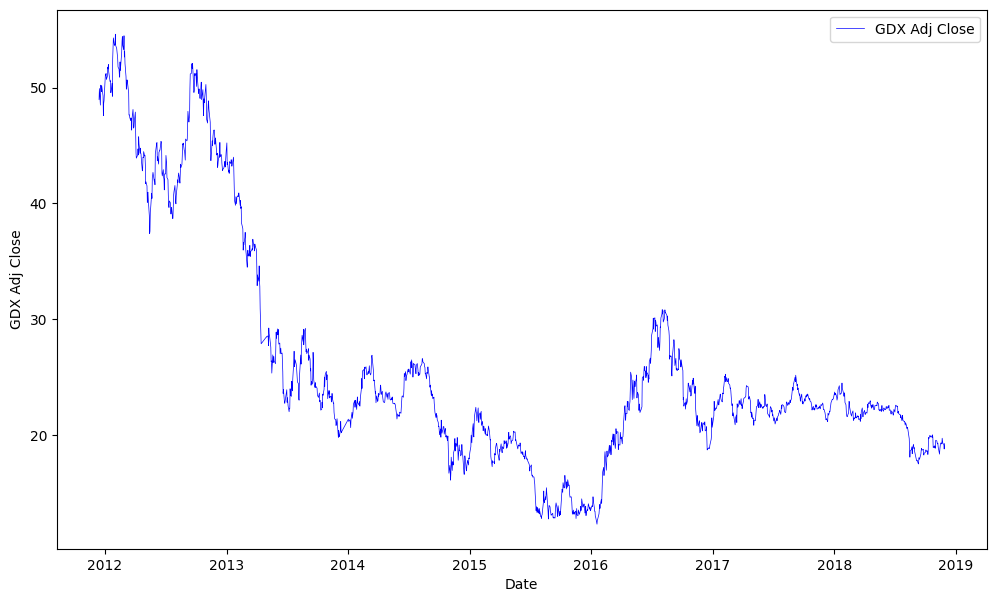

In [7]:
window = 0
tsa.line_plot(window=window)

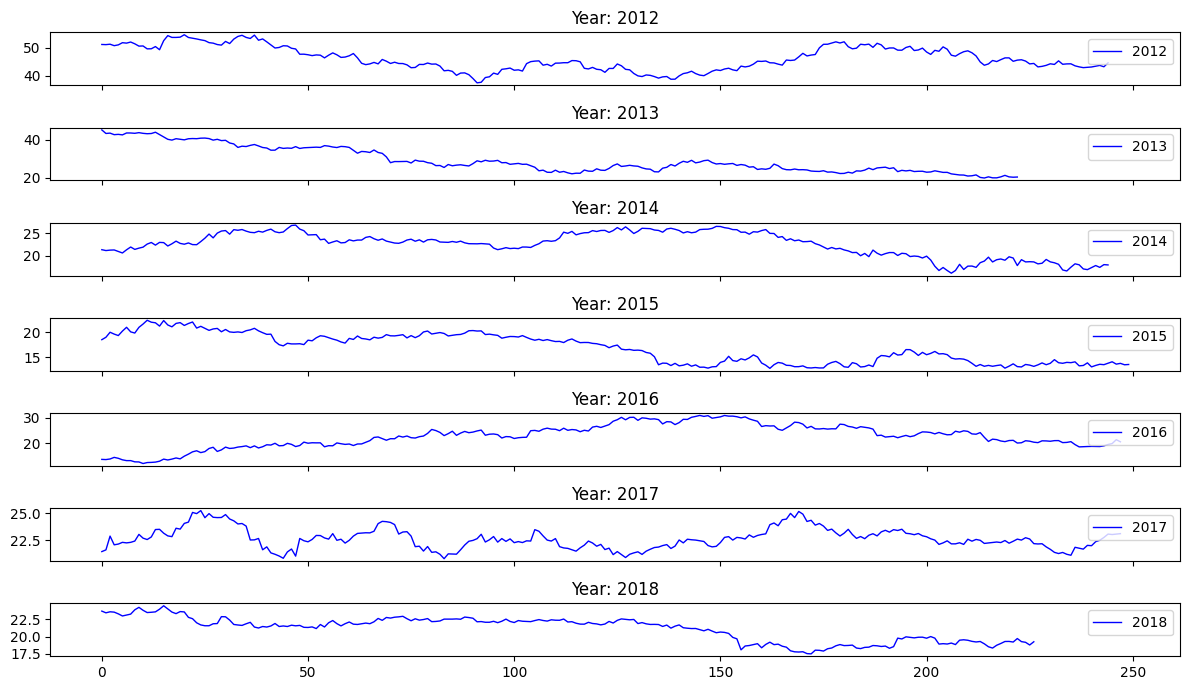

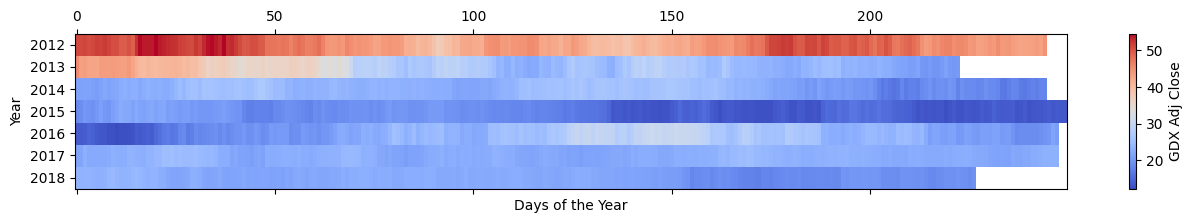

In [8]:
tsa.view_yearly(start='2012', end='2018')

# Naive model

In [9]:
class evaluate_persistence_model(object):
    def __init__(self, data, n_test, verbose=False):
        self.data = data
        self.n_test = n_test
        self.verbose = verbose
    
    def model_fit(self, train, config):
        return None
    
    def model_predict(self, model, history, offset):
        return history[-offset]

    def walk_forward_validation(self, data, n_test, cfg):
        predictions = []
        train, test = train_test_split(data, n_test)
        model = self.model_fit(train, cfg)
        history = list(train)
        for i in range(len(test)):
            yhat = self.model_predict(model, history, cfg)
            predictions.append(yhat)
            history.append(test[i])
        error = measure_rmse(test, predictions)
        if self.verbose:
            print(f'> {error:.3f}')
        return error
        
    def score_model(self, data, n_test, config, n_repeats=30):
        key = str(config)
        scores = [self.walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
        result = np.mean(scores)
        if self.verbose:
            print(f'Model[{key}] RMSE: {result:.3f}')
        return (key, result)
    
   
    def grid_search(self, cfg_list):
        print("Running grid search on model configurations...\n")
        self.cfg_list = cfg_list
        data = self.data
        n_test = self.n_test
        scores = []
        for cfg in tqdm(cfg_list, desc="Grid Search Progress"):
            scores.append(self.score_model(data, n_test, cfg))
        scores.sort(key=lambda tup: tup[1])
        return scores
     
if __name__ == '__main__':
    series = pd.read_csv(f'{data_path}/dataset.csv', header=None, parse_dates=True, index_col=0)
    data = series.values
    n_test = 252
    cfg_list = [1, 5, 21, 63, 126, 252]
    naive_model = evaluate_persistence_model(data, n_test)
    scores = naive_model.grid_search(cfg_list)
    
    top_configs = 3
    print(f'\nTop {top_configs} best configurations:')
    for cfg, error in scores[:top_configs]:
        print(f'Model[{cfg}]: RMSE {error:.5f}')

Running grid search on model configurations...



Grid Search Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.52it/s]


Top 3 best configurations:
Model[1]: RMSE 0.30852
Model[5]: RMSE 0.64401
Model[21]: RMSE 1.26771


# CNN-LSTM model

In [10]:
class evaluate_cnn_lstm_model(object):
    def __init__(self, data, n_test, verbose=False):
        self.data = data
        self.n_test = n_test
        self.verbose = verbose
    
    def model_fit(self, train, config):
        n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, n_diff, _ = config 
        n_input = n_seq * n_steps
        if n_diff > 0:
            train = difference(train, n_diff)
        data = series_to_supervised(train, n_in=n_input)
        train_X, train_y = data[:, :-1], data[:, -1]
        train_X = np.reshape(train_X, (len(train_X), n_seq, n_steps, 1))
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'), 
                                  input_shape=(None, n_steps, 1)))
        model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
        model.add(TimeDistributed(MaxPool1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(n_nodes, activation='relu'))
        model.add(Dense(n_nodes, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        es = EarlyStopping(monitor='loss', mode='min', patience=5, restore_best_weights=True)
        lr = ReduceLROnPlateau(monitor='loss', mode='min', patience=5)
        model.fit(train_X, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0, callbacks=[es, lr])
        return model             
    
    def model_predict(self, model, history, config):
        n_seq, n_steps, _, _, _, _, _, n_diff, _ = config
        n_input = n_seq * n_steps
        correction = 0.0
        if n_diff > 0:
            correction = history[-n_diff]
            history = difference(history, n_diff)
        x_input = np.array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        return correction + yhat[0]

    def walk_forward_validation(self, data, n_test, cfg):
        _, _, _, _, _, _, _, _, transform = cfg
        predictions = []
        train, test = train_test_split(data, n_test)
        if transform == 'standardize':
            train, test, mean, std = std_transform(train, test)
        elif transform == 'normalize':
            train, test, min_, max_ = norm_transform(train, test)
        model = self.model_fit(train, cfg)
        history = list(train)
        for i in range(len(test)):
            yhat = self.model_predict(model, history, cfg)
            predictions.append(yhat)
            history.append(test[i])
        if transform == 'standardize':
            predictions = inverse_std_transform(predictions, mean, std)
            test = inverse_std_transform(test, mean, std)
        elif transform == 'normalize':
            predictions = inverse_norm_transform(predictions, min_, max_)
            test = inverse_norm_transform(test, min_, max_)
        error = measure_rmse(test, predictions)
        if self.verbose:
            print(f'> {error:.3f}')
        return error
        
    def score_model(self, data, n_test, config, n_repeats=5):
        key = str(config)
        scores = [self.walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
        result = np.mean(scores)
        std = np.std(scores)
        if self.verbose:
            print(f'Model[{key}] RMSE: {result:.3f} (+/-{std:.3f})')
        return (key, result)
    
    def grid_search(self, cfg_list):
        print("Running grid search on model configurations...\n")
        self.cfg_list = cfg_list
        data = self.data
        n_test = self.n_test
        scores = []
        for cfg in tqdm(cfg_list, desc="Grid Search Progress"):
            scores.append(self.score_model(data, n_test, cfg))
        scores.sort(key=lambda tup: tup[1])
        return scores 
    
    def forecast_with_best_model(self, best_cfg):
        data = self.data
        n_test = self.n_test
        _, _, _, _, _, _, _, _, transform = best_cfg
        predictions = []
        train, test = train_test_split(data, n_test)
        if transform == 'standardize':
            train, test, mean, std = std_transform(train, test)
        elif transform == 'normalize':
            train, test, min_, max_ = norm_transform(train, test)
        model = self.model_fit(train, best_cfg)
        history = list(train)
        for i in range(len(test)):
            yhat = self.model_predict(model, history, best_cfg)
            predictions.append(yhat)
            history.append(test[i])
        if transform == 'standardize':
            predictions = inverse_std_transform(predictions, mean, std)
            test = inverse_std_transform(test, mean, std)
        elif transform == 'normalize':
            predictions = inverse_norm_transform(predictions, min_, max_)
            test = inverse_norm_transform(test, min_, max_)
        residuals = test.ravel() - predictions.ravel()
        return residuals
    
def model_configs():
    # define scope of configs
    n_seq = [3]
    n_steps = [12]
    n_filters = [32, 64]
    n_kernel = [3, 5]
    n_nodes = [100, 200]
    n_epochs = [20]
    n_batch = [32, 64]
    n_diff = [1]
    transform = [None, 'standardize', 'normalize']
    configs = []
    for a in n_seq:
        for b in n_steps:
            for c in n_filters:
                for d in n_kernel:
                    for e in n_nodes:
                        for f in n_epochs:
                            for g in n_batch:
                                for h in n_diff:
                                    for i in transform:
                                        cfg = [a, b, c, d, e, f, g, h, i]
                                        configs.append(cfg)
    print(f'Total configs: {len(configs)}')
    return configs
        
if __name__ == '__main__':
    series = pd.read_csv(f'{data_path}/dataset.csv', header=None, parse_dates=True, index_col=0)
    data = series.values
    n_test = 252
    cfg_list = model_configs()
    cnn_lstm_model = evaluate_cnn_lstm_model(data, n_test)
    scores = cnn_lstm_model.grid_search(cfg_list)
    
    top_configs = 3
    print(f'\nTop {top_configs} best configurations:')
    for cfg, error in scores[:top_configs]:
        print(f'Model[{cfg}]: RMSE {error:.5f}')

Total configs: 48
Running grid search on model configurations...



Grid Search Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [1:09:32<00:00, 86.93s/it]


Top 3 best configurations:
Model[[3, 12, 64, 5, 200, 20, 64, 1, 'standardize']]: RMSE 0.30775
Model[[3, 12, 32, 5, 100, 20, 64, 1, 'standardize']]: RMSE 0.30781
Model[[3, 12, 32, 5, 200, 20, 64, 1, 'standardize']]: RMSE 0.30817


# Model Diagnostics

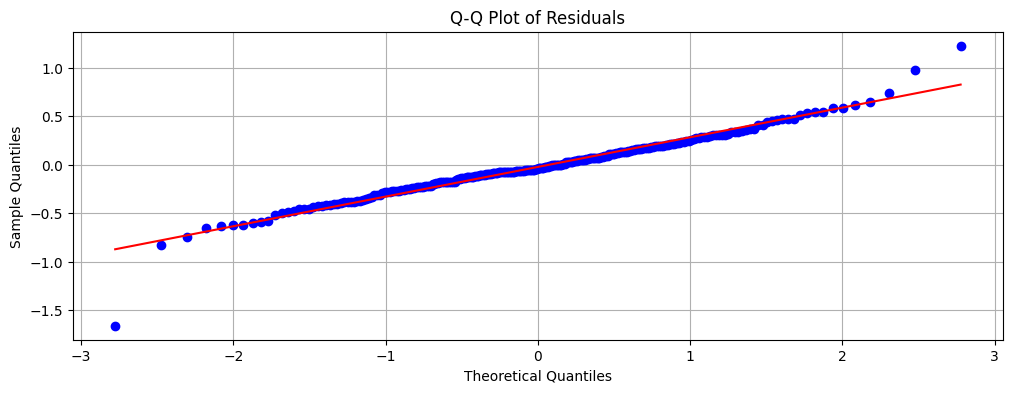

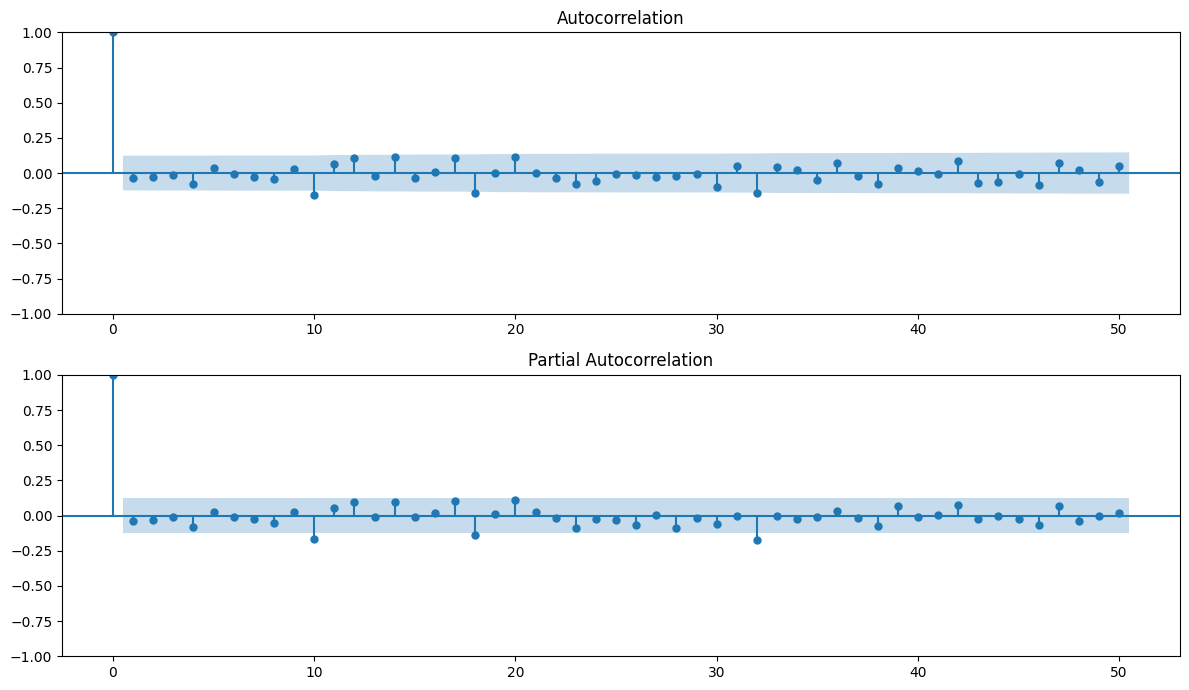

In [11]:
best_cfg, _ = scores[0]
best_cfg =  ast.literal_eval(best_cfg)
residuals = cnn_lstm_model.forecast_with_best_model(best_cfg)

plt.figure(figsize=(12, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

plot_acf_pacf(residuals, lags=50)

# Save best model configuration

In [12]:
with open(f'{data_path}/best_cfg.json', 'w') as file:
    json.dump(best_cfg, file)
print('Configuration saved successfully.')

Configuration saved successfully.


# Model validation

Configuration loaded successfully: [3, 12, 64, 5, 200, 20, 64, 1, 'standardize']
Model saved successfully
RMSE: 0.45128
> Expected=19.069, Predicted=19.211
> Expected=18.990, Predicted=19.008
> Expected=19.338, Predicted=18.991
> Expected=19.497, Predicted=19.299
> Expected=19.606, Predicted=19.447
> Expected=20.094, Predicted=19.663
> Expected=20.024, Predicted=20.131
> Expected=19.905, Predicted=19.983
> Expected=20.332, Predicted=19.897
> Expected=20.372, Predicted=20.363
> Expected=20.014, Predicted=20.394
> Expected=20.502, Predicted=20.055
> Expected=20.979, Predicted=20.529
> Expected=19.845, Predicted=20.925
> Expected=20.670, Predicted=19.831
> Expected=20.440, Predicted=20.678
> Expected=21.090, Predicted=20.353
> Expected=20.620, Predicted=21.093
> Expected=20.970, Predicted=20.679
> Expected=20.600, Predicted=20.939
> Expected=21.090, Predicted=20.602


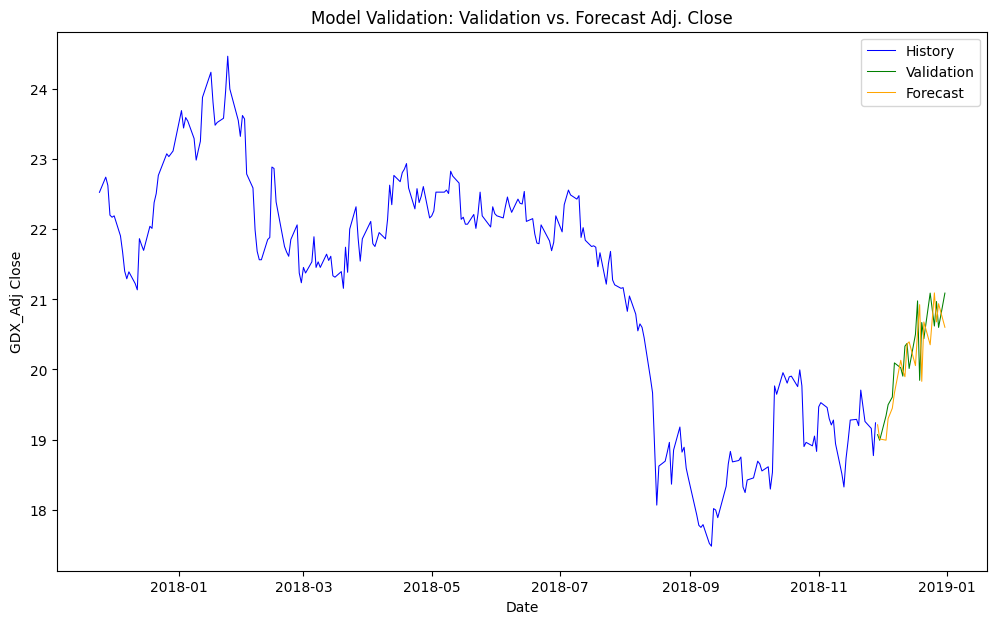

In [24]:
class validate_cnn_lstm_model(object):
    def __init__(self, train, val, best_config):
        self.train = train
        self.val = val
        self.best_config = best_config
        
    def fit_best_model(self, train, config):
        n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, n_diff, _ = config 
        n_input = n_seq * n_steps
        if n_diff > 0:
            train = difference(train, n_diff)
        data = series_to_supervised(train, n_in=n_input)
        train_X, train_y = data[:, :-1], data[:, -1]
        train_X = np.reshape(train_X, (len(train_X), n_seq, n_steps, 1))
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'), 
                                  input_shape=(None, n_steps, 1)))
        model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
        model.add(TimeDistributed(MaxPool1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(n_nodes, activation='relu'))
        model.add(Dense(n_nodes, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        es = EarlyStopping(monitor='loss', mode='min', patience=5, restore_best_weights=True)
        lr = ReduceLROnPlateau(monitor='loss', mode='min', patience=5)
        model.fit(train_X, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0, callbacks=[es, lr])
        return model
    
    def model_predict(self, model, history, config):
        n_seq, n_steps, _, _, _, _, _, n_diff, _ = config
        n_input = n_seq * n_steps
        correction = 0.0
        if n_diff > 0:
            correction = history[-n_diff]
            history = difference(history, n_diff)
        x_input = np.array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        return correction + yhat[0]
    
    def walk_forward_validation(self):
        train = self.train
        val = self.val
        config = self.best_config
        _, _, _, _, _, _, _, _, transform = config
        predictions = []
        if transform == 'standardize':
            train, val, mean, std = std_transform(train, val)
        elif transform == 'normalize':
            train, val, min_, max_ = norm_transform(train, val)
        model = self.fit_best_model(train, config)
        model.save(f'{data_path}/cnn_lstm.keras')
        print('Model saved successfully')
        history = list(train)
        for i in range(len(val)):
            yhat = self.model_predict(model, history, config)
            predictions.append(yhat)
            history.append(val[i])
        if transform == 'standardize':
            predictions = inverse_std_transform(predictions, mean, std)
            val = inverse_std_transform(val, mean, std)
        elif transform == 'normalize':
            predictions = inverse_norm_transform(predictions, min_, max_)
            val = inverse_norm_transform(val, min_, max_)
        rmse = measure_rmse(val, predictions)
        print(f'RMSE: {rmse:.5f}')
        return predictions

with open(f'{data_path}/best_cfg.json', 'r') as file:
    best_cfg = json.load(file)
print('Configuration loaded successfully:', best_cfg)
    
series = pd.read_csv(f'{data_path}/dataset.csv', header=None, parse_dates=True, index_col=0)
X = series.values.astype('float32')

validation = pd.read_csv(f'{data_path}/validation.csv', header=None, index_col=0, parse_dates=True)
y = validation.values.astype('float32')

validate = validate_cnn_lstm_model(train=X, val=y, best_config=best_cfg)
predictions = validate.walk_forward_validation()

for i, j in zip(list(y.ravel()), list(predictions.ravel())):
    print(f'> Expected={i:.3f}, Predicted={j:.3f}')

residuals = y - predictions

history_size = 252
plt.figure(figsize=(12, 7))
plt.plot(series.index[-history_size:], X[-history_size:], color='blue', label='History', lw=.75)

plt.plot(
    series.index[-history_size:].union(validation.index), 
    [None for _ in X[-history_size:]] + [x for x in y.ravel()], 
    color='green', 
    label='Validation',
    lw=.75
)

plt.plot(
    series.index[-history_size:].union(validation.index), 
    [None for _ in X[-history_size:]] + [x for x in predictions.ravel()], 
    color='orange', 
    label='Forecast', 
    lw=.75
)

plt.title('Model Validation: Validation vs. Forecast Adj. Close')
plt.xlabel('Date')
plt.ylabel('GDX_Adj Close', color='black')
plt.legend()
plt.tick_params(axis='y', labelcolor='black')
plt.show()

# Conclusion and recommendations

In this end-to-end project, we developed a univariate convolutional-long short-term memory (CNN-LSTM) model to forecast the daily price of gold. We used the persistence model as a baseline, which recorded an RMSE score of 0.30852. In contrast, our CNN-LSTM model outperformed this baseline, achieving an RMSE of 0.30775. An analysis of the residuals indicates that they follow a Gaussian distribution, although with fatter tails. Additionally, the autocorrelation plots show no evidence of serial correlation, suggesting that the CNN-LSTM model has successfully fitted the data. The model achieved the RMSE of 0.45128 using the out-of-sample validation dataset.

There are several potential avenues for improvement that could enhance performance. One approach is to incorporate predictive variables, which may lead to more accurate results. Additionally, exploring other artificial neural network (ANN) models, such as recurrent neural networks (RNN) and long short-term memory (LSTM) networks along with their variants, could also yield beneficial outcomes.